# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## Persiapan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.shape

(26496, 1)

In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<AxesSubplot:xlabel='datetime'>

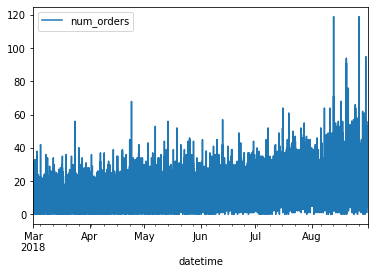

In [7]:
data.plot()

Data terlihat baik baik saja tidak ada masalah.

Resample Data 1 Jam

In [8]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<AxesSubplot:xlabel='datetime'>

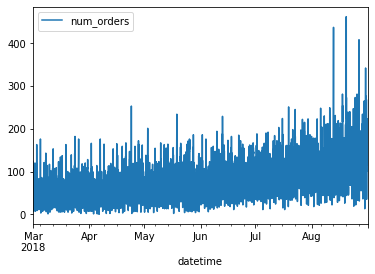

In [9]:
data.plot()

Data sudah di resample menjadi 1 Jam

In [10]:
data.shape

(4416, 1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analisis

Sebelum melangkah lebih jauh, dilakukan analisa tentang tren, seasonal, dan residual.

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
decomposed = seasonal_decompose(data)

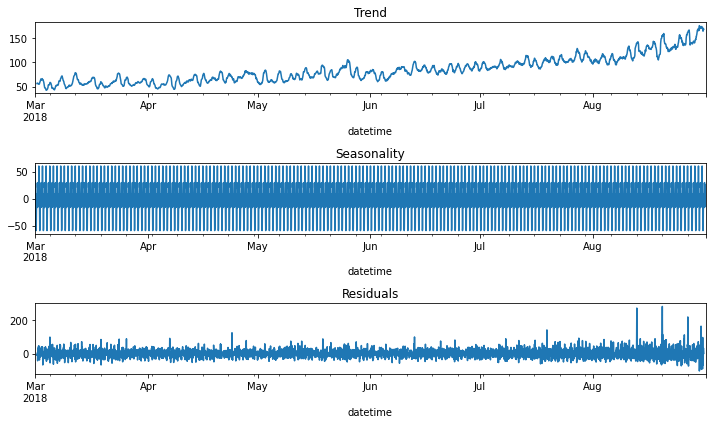

In [14]:
plt.figure(figsize=(10,6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Seasonalitynya memiliki pola yang hampir sama, selanjutnya kita lihat bagaimana seasonalitynya dalam 1 hari.

<AxesSubplot:xlabel='datetime'>

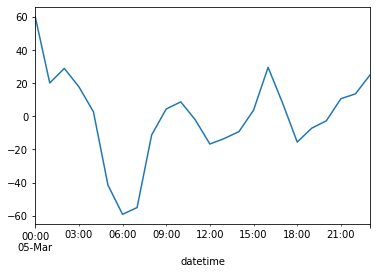

In [15]:
decomposed.seasonal['2018-03-5'].plot(ax=plt.gca())

Terlihat bahwa order taxi turun di jam 12 hingga jam 6, lalu naik kembali di jam 9an, dan kembali turun sedikit hingga jam 12, dan mengalami kenaikan lagi di jam 15, lalu turun kembali hingga jam 18 dan terus naik hingga jam 12 malam.

Insight yang didapatkan adalah:
1. Untuk Trend dalam 6 bulan, terlihat bahwa pesanan taxi selalu naik.
2. Pesanan taxi di bandara memiliki peak saat jam 3 pagi, jam 9 pagi, jam 4 sore dan seterusnya.
3. Pesanan taxi di bandara memliki nilai minimum di jam 6 pagi, hal ini dikarenakan tidak banyak pesawat yang tiba di bandara pada jam 6 pagi.
4. Untuk pesanan taxi di tengah malam bisa disebabkan karena transportasi umum yang lain bisa jadi tidak beroperasi, biasanya angkutan umum (Jika di Indonesia, hanya beroperasi hingga jam 6-9 malam)
5. Untuk pesanan taxi dari jam 9 hingga jam 3 sore sebenarnya memang memiliki nilai yang lebih baik dibanding jam 6, namun pada jam tersebut beberapa orang bisa saja memilih transportasi umum yang lain.


## Pelatihan

Pelatihan dimulai dengan membuat fitur yang dibutuhkan terlebih dahulu yaitu month, day, dayofweek, dan hour.

In [16]:
def make_features(data, max_lag=4, rolling_mean_size=10):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data)
data = data.dropna()
print(data.shape)
data.head()

(4406, 10)


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,40.1


Selanjutnya dilakukan pemisahan data dengan rasio 70% untuk training, 20% untuk valid, dan sisanya untuk dataset test.

In [51]:
from sklearn.model_selection import train_test_split

test, sisa = train_test_split(data, shuffle=False, train_size=0.1)
train, valid = train_test_split(sisa, shuffle=False, train_size=0.78)
##Sisa adalah gabungan dari train dan valid
print(train.index.min(), train.index.max())
print(train.shape)
print(f'Dataset dibagi train menjadi {train.shape[0]/data.shape[0]:.2f}')
print(valid.index.min(), valid.index.max())
print(valid.shape)
print(f'Dataset dibagi valid menjadi {valid.shape[0]/data.shape[0]:.2f}')
print(test.index.min(), test.index.max())
print(test.shape)
print(f'Dataset dibagi test menjadi {test.shape[0]/data.shape[0]:.2f}')

2018-03-19 18:00:00 2018-07-26 14:00:00
(3093, 10)
Dataset dibagi train menjadi 0.70
2018-07-26 15:00:00 2018-08-31 23:00:00
(873, 10)
Dataset dibagi valid menjadi 0.20
2018-03-01 10:00:00 2018-03-19 17:00:00
(440, 10)
Dataset dibagi test menjadi 0.10


Selanjutnya mendefinisikan features dan target

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Metric yang akan digunakan adalah RMSE

In [19]:
from sklearn.metrics import mean_squared_error

def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

Sanity check dilakukan terlebih dahulu untuk dijadikan baseline.

In [20]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE dengan data sebelumnya:', rmse(test['num_orders'], pred_previous['num_orders']))
pred_mean = np.ones(test['num_orders'].shape) * train['num_orders'].mean()
print('RMSE dengan mean:', rmse(test['num_orders'], pred_mean))

RMSE dengan data sebelumnya: 29.33257574779276
RMSE dengan mean: 35.49626961184421


### Model Regresi Linear

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [22]:
pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

In [23]:
print("Train RMSE:", rmse(target_train, pred_train))
print("Valid RMSE:", rmse(target_valid, pred_valid))

Train RMSE: 29.49942363448474
Valid RMSE: 47.62901560531077


### LightGBM

In [24]:
import lightgbm as lgb

In [25]:
for i in [100,250,500,750, 1000]:
    model = lgb.LGBMRegressor(n_estimators=i, random_state=1, objective='rmse')
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    print("Estimators:", i)
    print('Train RMSE',rmse(target_train, pred_train))
    print('Valid RMSE:', rmse(target_valid, pred_valid))

Estimators: 100
Train RMSE 13.386169525570608
Valid RMSE: 45.62549710303614
Estimators: 250
Train RMSE 8.717110243262425
Valid RMSE: 46.615335606027145
Estimators: 500
Train RMSE 4.909544937612653
Valid RMSE: 46.92151423712726
Estimators: 750
Train RMSE 2.928342854582913
Valid RMSE: 46.89148139161372
Estimators: 1000
Train RMSE 1.8634819592418848
Valid RMSE: 46.91944468064785


Nilai train RMSE nya terlalu jauh dengan valid RMSE, hal ini menandakan adanya overfitting, sehingga selanjutnya dilakukan tuning pada learning ratenya.

In [26]:
for i in [100,250,500,750, 1000]:
    model = lgb.LGBMRegressor(n_estimators=i,learning_rate=0.01, random_state=1, objective='rmse')
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    print("Estimators:", i)
    print("Train RMSE:", rmse(target_train, pred_train))
    print("Valid RMSE:", rmse(target_valid, pred_valid)) 

Estimators: 100
Train RMSE: 23.69247219589766
Valid RMSE: 55.89818247279005
Estimators: 250
Train RMSE: 19.002397919443556
Valid RMSE: 48.28922813769986
Estimators: 500
Train RMSE: 16.34224502123891
Valid RMSE: 45.74269119298876
Estimators: 750
Train RMSE: 14.731909828524794
Valid RMSE: 45.48258180197146
Estimators: 1000
Train RMSE: 13.521673519194206
Valid RMSE: 45.56922282841021


Didapatkan bahwa n_estimator 1000 dengan learning rate 0.01 mendapatkan nilai rmse yang paling baik. Namun estimator masih bisa ditingkatkan.

In [27]:
for i in [100,250,500,750, 1000, 1500, 2000]:
    model = lgb.LGBMRegressor(n_estimators=i,learning_rate=0.01, random_state=1, objective='rmse')
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    print("Estimators:", i)
    print("Train RMSE:", rmse(target_train, pred_train))
    print("Valid RMSE:", rmse(target_valid, pred_valid)) 

Estimators: 100
Train RMSE: 23.69247219589766
Valid RMSE: 55.89818247279005
Estimators: 250
Train RMSE: 19.002397919443556
Valid RMSE: 48.28922813769986
Estimators: 500
Train RMSE: 16.34224502123891
Valid RMSE: 45.74269119298876
Estimators: 750
Train RMSE: 14.731909828524794
Valid RMSE: 45.48258180197146
Estimators: 1000
Train RMSE: 13.521673519194206
Valid RMSE: 45.56922282841021
Estimators: 1500
Train RMSE: 11.54335429444551
Valid RMSE: 46.053437785826745
Estimators: 2000
Train RMSE: 10.03609747588255
Valid RMSE: 46.26592465384159


Nilai maksimum Valid RMSE terbaik didapatkan saat estimator di 1000, berarti difix kan bahwa estimator yang akan dipakai adalah 1000, selanjutnya tuning learning rate.

In [28]:
for i in [0.005,0.01,0.05,0.1]:
    model = lgb.LGBMRegressor(n_estimators=1000,learning_rate=i, random_state=1, objective='rmse')
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    print("Learning Rate:", i)
    print("Train RMSE:", rmse(target_train, pred_train))
    print("Valid RMSE:", rmse(target_valid, pred_valid)) 

Learning Rate: 0.005
Train RMSE: 16.35543567817773
Valid RMSE: 45.89720009360671
Learning Rate: 0.01
Train RMSE: 13.521673519194206
Valid RMSE: 45.56922282841021
Learning Rate: 0.05
Train RMSE: 5.041141188665493
Valid RMSE: 47.17006569007668
Learning Rate: 0.1
Train RMSE: 1.8634819592418848
Valid RMSE: 46.91944468064785


Learning Rate 0.01 menjadi yang terbaik.

Hyperparameter yang digunakan adalah 1000 estimator dengan learning rate sebesar 0.01.

### CatBoost

In [29]:
from catboost import CatBoostRegressor

In [30]:
for i in [100, 250, 500, 750, 1000, 1500, 2000]:
    for j in [0.005,0.01,0.05,0.1]:
        model = CatBoostRegressor(n_estimators=i, learning_rate = j, random_state=1, verbose=False)
        model.fit(features_train, target_train)
        pred_train = model.predict(features_train)
        pred_valid = model.predict(features_valid)
        print("Estimators:", i)
        print('Learning Rate:', j)
        print("Train RMSE:", rmse(target_train, pred_train))
        print("Valid RMSE:", rmse(target_valid, pred_valid)) 

Estimators: 100
Learning Rate: 0.005
Train RMSE: 29.958615110270294
Valid RMSE: 65.33044306392969
Estimators: 100
Learning Rate: 0.01
Train RMSE: 26.902000286135983
Valid RMSE: 60.52514625568178
Estimators: 100
Learning Rate: 0.05
Train RMSE: 20.891814640983334
Valid RMSE: 48.56995738586398
Estimators: 100
Learning Rate: 0.1
Train RMSE: 18.892486469274996
Valid RMSE: 47.18752830144062
Estimators: 250
Learning Rate: 0.005
Train RMSE: 25.904596812452603
Valid RMSE: 58.55757762335717
Estimators: 250
Learning Rate: 0.01
Train RMSE: 23.090406224725722
Valid RMSE: 52.87518738206717
Estimators: 250
Learning Rate: 0.05
Train RMSE: 18.091682478113565
Valid RMSE: 46.015292716007146
Estimators: 250
Learning Rate: 0.1
Train RMSE: 15.39175312485899
Valid RMSE: 46.9167953152107
Estimators: 500
Learning Rate: 0.005
Train RMSE: 23.13791146613296
Valid RMSE: 52.83777704130401
Estimators: 500
Learning Rate: 0.01
Train RMSE: 20.878770463094728
Valid RMSE: 48.61322147850758
Estimators: 500
Learning Rate: 

Karena terlihat bahwa model mengalami overfitting, maka dilakukan tuning terhadap learning rate.

Hyperparameter yang akan digunakan adalah 1000 estimator dengan learning rate sebesar 0,01.

### Model XGBoost

In [31]:
import xgboost as xg

for i in [100, 250, 500, 750, 1000, 1500, 2000]:
    model = xg.XGBRegressor(objective ='reg:linear',n_estimators = i, seed = 123, learning_rate=0.01)
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    print("Estimators:", i)
    print("Train RMSE:", rmse(target_train, pred_train))
    print("Valid RMSE:", rmse(target_valid, pred_valid))

[21:07:22] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Estimators: 100
Train RMSE: 37.06289400829774
Valid RMSE: 78.448862803988
[21:07:24] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Estimators: 250
Train RMSE: 19.531646933243888
Valid RMSE: 53.64977119031004
[21:07:29] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Estimators: 500
Train RMSE: 15.142756462225925
Valid RMSE: 47.21388622252618
[21:07:38] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Estimators: 750
Train RMSE: 13.630582406356805
Valid RMSE: 46.45619781492701
[21:07:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Estimators: 1000
Train RMSE: 12.394498752622054
Valid RMSE: 46.5192977802421
[21:08:11] WARNING: ../

Dengan mempertimbangkan train RMSE dengan Valid RMSE, dan model lain, maka estimator dan learning rate akan disamakan menjadi 1000 estimator dengan learning rate 0,01.

### Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
for i in [1, 2, 4, 6, 8, 10, None]:
    for n in [50, 100, 150, 200, 250]:
        model = RandomForestRegressor(max_depth=i, n_estimators=n)
        model.fit(features_train, target_train)

        pred_train = model.predict(features_train)
        pred_valid = model.predict(features_valid)
        print("Depth:", i)
        print("Estimator:", n)
        print("Train RMSE:", rmse(target_train, pred_train))
        print("Valid RMSE:", rmse(target_valid, pred_valid))

Depth: 1
Estimator: 50
Train RMSE: 31.933932280195716
Valid RMSE: 65.9882353403216
Depth: 1
Estimator: 100
Train RMSE: 31.887179148821936
Valid RMSE: 66.03003697255046
Depth: 1
Estimator: 150
Train RMSE: 31.90323930128242
Valid RMSE: 65.75021591882103
Depth: 1
Estimator: 200
Train RMSE: 31.903312078776008
Valid RMSE: 65.77282509620645
Depth: 1
Estimator: 250
Train RMSE: 31.886567494125757
Valid RMSE: 65.83708592680418
Depth: 2
Estimator: 50
Train RMSE: 28.701103371351312
Valid RMSE: 64.00970327616815
Depth: 2
Estimator: 100
Train RMSE: 28.7135033645213
Valid RMSE: 64.1732550379808
Depth: 2
Estimator: 150
Train RMSE: 28.746885589176493
Valid RMSE: 63.83714951480059
Depth: 2
Estimator: 200
Train RMSE: 28.73823716106231
Valid RMSE: 63.917508075895995
Depth: 2
Estimator: 250
Train RMSE: 28.68534416968366
Valid RMSE: 63.769994764589455
Depth: 4
Estimator: 50
Train RMSE: 24.776359167703063
Valid RMSE: 56.01609649255276
Depth: 4
Estimator: 100
Train RMSE: 24.849937592468976
Valid RMSE: 56.054

Didapatkan hyperparameter terbaik adalah Depth None, dengan estimator adalah 150.

## Pengujian

Pengujian akan dilakukan dengan training dari dataset gabungan dari dataset training dan valid karena sampel tes hanya 10% dari dataset sehingga sisanya adalah training.

Informasi yang mungkin terlewat, variabel sisa adalah dataset pertama kali dipisah menjadi 9:1, sisa dan dataset tes.

In [34]:
features_sisa = sisa.drop(['num_orders'], axis=1)
target_sisa = sisa['num_orders']

### Model Regresi Linear

In [35]:
%%time

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(features_sisa, target_sisa)

CPU times: user 8.69 ms, sys: 3.9 ms, total: 12.6 ms
Wall time: 28.5 ms


LinearRegression()

In [36]:
%%time

pred_test = model.predict(features_test)
pred_valid = model.predict(features_valid)

CPU times: user 5.49 ms, sys: 3.9 ms, total: 9.4 ms
Wall time: 4.39 ms


In [37]:
print("Valid RMSE:", rmse(target_valid, pred_valid))
print("Test RMSE:", rmse(target_test, pred_test))


Valid RMSE: 45.62398548010929
Test RMSE: 27.635942638669917


### Model XGBoost

In [38]:
%%time
import xgboost as xg

model = xg.XGBRegressor(objective ='reg:linear',n_estimators = 1000,learning_rate=0.01, seed = 123)
model.fit(features_sisa, target_sisa)

[21:10:02] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 21 s, sys: 199 ms, total: 21.2 s
Wall time: 21.4 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [39]:
%%time
pred_test = model.predict(features_test)
pred_valid = model.predict(features_valid)

CPU times: user 86.5 ms, sys: 57 µs, total: 86.6 ms
Wall time: 46.3 ms


In [40]:
print("Valid RMSE:", rmse(target_valid, pred_valid))
print("Test RMSE:", rmse(target_test, pred_test))


Valid RMSE: 14.978505896550828
Test RMSE: 20.72121505722815


### Random Forest Regressor

In [41]:
%%time
model = RandomForestRegressor(max_depth=None, n_estimators=100)
model.fit(features_sisa, target_sisa)

CPU times: user 2.2 s, sys: 707 µs, total: 2.2 s
Wall time: 2.21 s


RandomForestRegressor()

In [42]:
%%time
pred_test = model.predict(features_test)
pred_valid = model.predict(features_valid)

CPU times: user 49.5 ms, sys: 7.71 ms, total: 57.2 ms
Wall time: 54.7 ms


In [43]:
print("Valid RMSE:", rmse(target_valid, pred_valid))
print("Test RMSE:", rmse(target_test, pred_test))


Valid RMSE: 12.98270576676318
Test RMSE: 21.88956139246617


Didapatkan hyperparameter terbaik adalah Depth None, dengan estimator adalah 100.

### LightGBM

In [44]:
%%time
model = lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.01, random_state=1, objective='rmse')
model.fit(features_sisa, target_sisa)

CPU times: user 4.43 s, sys: 99.3 ms, total: 4.53 s
Wall time: 4.58 s


LGBMRegressor(learning_rate=0.01, n_estimators=1000, objective='rmse',
              random_state=1)

In [45]:
%%time
pred_test = model.predict(features_test)
pred_valid = model.predict(features_valid)

CPU times: user 192 ms, sys: 108 µs, total: 192 ms
Wall time: 195 ms


In [46]:
print("Valid RMSE:", rmse(target_valid, pred_valid))
print("Test RMSE:", rmse(target_test, pred_test))


Valid RMSE: 18.76309422273764
Test RMSE: 20.583412643127772


### CatBoost

In [47]:
from catboost import CatBoostRegressor

In [48]:
%%time
model = CatBoostRegressor(n_estimators=1000, learning_rate = 0.01, random_state=1, verbose=False)
model.fit(features_sisa, target_sisa)

CPU times: user 2.29 s, sys: 4.59 ms, total: 2.29 s
Wall time: 2.41 s


In [49]:
%%time
pred_test = model.predict(features_test)
pred_valid = model.predict(features_valid)

CPU times: user 7.27 ms, sys: 38 µs, total: 7.31 ms
Wall time: 6.16 ms


In [50]:
print("Valid RMSE:", rmse(target_valid, pred_valid))
print("Test RMSE:", rmse(target_test, pred_test))


Valid RMSE: 27.276809400507204
Test RMSE: 20.384048847295798


Dengan mempertimbangkan perbedaan RMSE yang didapatkan dari train dan valid, didapatkan hyperparameter terbaik adalah 1000 estimator dengan learning rate sebesar 0,05.

## Kesimpulan

Dari hasil analisa yang telah dilakukan, didapatkan

1. Nilai test RMSE selain model dari linear regression memiliki nilai yang hampir mirip yaitu sekitar 20 hingga 21.
2. Model yang digunakan semuanya dituning dengan hyperparameter yang sama kecuali random forest. Yaitu iterasi sebanyak 1000 kali dan dengan learning rate sebesar 0.01.
3. Jika harus memilih model yang terbaik, maka dalam Project yang dibuat kali ini, LightGBM adalah model yang akan saya pilih, hal ini dikarenakan rmse pada valid dan test tidak berbeda jauh (18 untuk validation data dan 20 untuk test data), ini didasari dengan model yang ditraining dengan sedikit data dari dataset valid memiliki nilai yang "hampir" sama dengan hasil prediksi yang sama sekali tidak berhubungan dengan training modelnya.